In [1]:
import matplotlib
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
import gseapy as gp

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import PCA
from cmapPy.pandasGEXpress.parse import parse
from scipy import stats
from pandas import DataFrame as df
from matplotlib import pyplot as plt
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Global path

In [2]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
data_home = poseidon_home + 'data/'
gsea_home = poseidon_home + 'GSEA/'
cmap_home = data_home + 'CMAP2020_Cancer/'
shift_home = poseidon_home + 'shift_ability/'
auc_home = poseidon_home + 'panels/Figure1/auc/'

# Data

In [3]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

,Official NCBI gene symbol
Official NCBI gene id,
5720,PSME1
7416,VDAC1
55847,CISD1
10174,SORBS3
25803,SPDEF
...,...
5137,PDE1C
51233,DRICH1
4340,MOG


In [4]:
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()
compound_info

,pert_id,target,moa,canonical_smiles,inchi_key,compound_aliases
cmap_name,,,,,,
1-EBIO,BRD-K70586315,NaN,NaN,CCn1c2ccccc2[nH]c1=O,CXUCKELNYMZTRT-UHFFFAOYSA-N,NaN
1-HYDROXYANTHRAQUINONE,BRD-K62620932,NaN,NaN,NaN,NaN,NaN
1-HYDROXYPHENAZINE,BRD-K66151076,NaN,NaN,NaN,NaN,NaN
1-NAPHTHYLAMINE,BRD-K05741221,NaN,NaN,NaN,NaN,NaN
1-NITRONAPHTHALENE,BRD-K72839221,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
zolpidem,BRD-K44876623,GABRA1,Benzodiazepine receptor agonist,CN(C)C(=O)Cc1c(nc2ccc(C)cn12)-c1ccc(C)cc1,ZAFYATHCZYHLPB-UHFFFAOYSA-N,NaN
zonisamide,BRD-A28095882,SCN11A,Sodium channel blocker,CN1C2CCC1CC(C2)OC(c3ccccc3)c4ccccc4N,KZFDKINRISJFCO-UHFFFAOYSA-N,NaN
zopiclone,BRD-A34309505,GABRA1,GABA receptor agonist,CN1CCN(CC1)C(=O)OC2N(C(=O)c3nccnc23)c4ccc(Cl)cn4,GBBSUAFBMRNDJC-UHFFFAOYSA-N,NaN


# 1. CXCL10 expression in GSE91061

## 1.1 Pre-processing

In [5]:
# GSE91061 original expression
expr_91061 = pd.read_csv(data_home + 'GSE91061/GSE91061_BMS038109Sample.hg19KnownGene.fpkm.csv',
                          index_col=0, header=0, sep=',')

expr_91061 = expr_91061[expr_91061.index.isin(bing_landmark.index)]
expr_91061 = expr_91061.rename(index=bing_landmark['Official NCBI gene symbol'])

# overlap with the L1000 space
expr_91061 = expr_91061[expr_91061.index.isin(bing_landmark['Official NCBI gene symbol'])]

# read clinical information
info_91061 = pd.read_csv(data_home + 'GSE91061/GSE91061_patient_info.csv',
                          index_col=0, header=0, sep=',').T
print(expr_91061.shape, info_91061.shape)

(10158, 109) (109, 2)


In [6]:
# get the paired sample list
timepoint_91061 = df(columns=['Pre', 'On', 'response'])
for p in info_91061.index:
    tmp_cat = p.split('_')[1]
    tmp_p = p.split('_')[0]
    timepoint_91061.at[tmp_p, tmp_cat] = p
    timepoint_91061.at[tmp_p, 'response'] = info_91061.loc[p, 'response'].split(': ')[1]

# get the patients with paired samples
paired_91061 = timepoint_91061.dropna(axis=0, how='any')

print(timepoint_91061.shape, paired_91061.shape)

(65, 3) (43, 3)


In [7]:
response_lut = {'PD': 'crimson', 'SD': 'royalblue', 'PRCR': 'cornflowerblue', 'UNK': 'grey'}
patient_color = df(index=info_91061.index, columns=['response', 'response_color', 'time', 'time_color'])
for p in paired_91061.index:
    patient_color.at[paired_91061.loc[p, 'Pre'], 'time'] = 'Pre'
    patient_color.at[paired_91061.loc[p, 'On'], 'time'] = 'On'
    patient_color.at[paired_91061.loc[p, 'Pre'], 'time_color'] = 'violet'
    patient_color.at[paired_91061.loc[p, 'On'], 'time_color'] = 'gold'
    patient_color.at[paired_91061.loc[p, 'Pre'], 'response'] = paired_91061.loc[p, 'response']
    patient_color.at[paired_91061.loc[p, 'On'], 'response'] = paired_91061.loc[p, 'response']
    patient_color.at[paired_91061.loc[p, 'Pre'], 'response_color'] = response_lut[paired_91061.loc[p, 'response']]
    patient_color.at[paired_91061.loc[p, 'On'], 'response_color'] = response_lut[paired_91061.loc[p, 'response']]
patient_color = patient_color.dropna(axis=0, how='any')

In [8]:
# add color for paired_91061
for p in paired_91061.index:
    paired_91061.at[p, 'response_color'] = response_lut[paired_91061.loc[p, 'response']]

paired_91061['response'].value_counts()

/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dyang-server/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


PD      18
SD      15
PRCR     9
UNK      1
Name: response, dtype: int64

In [9]:
log2exp2_91061 = np.log2(expr_91061 + 1) # log2FPKM

# collapse duplicates
log2exp2_91061 = log2exp2_91061.groupby(level=0).mean()

log2exp2_91061 = log2exp2_91061[log2exp2_91061 > 0.].dropna(axis=0, how='all').fillna(0.)
print(log2exp2_91061.shape)

(10157, 109)


/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


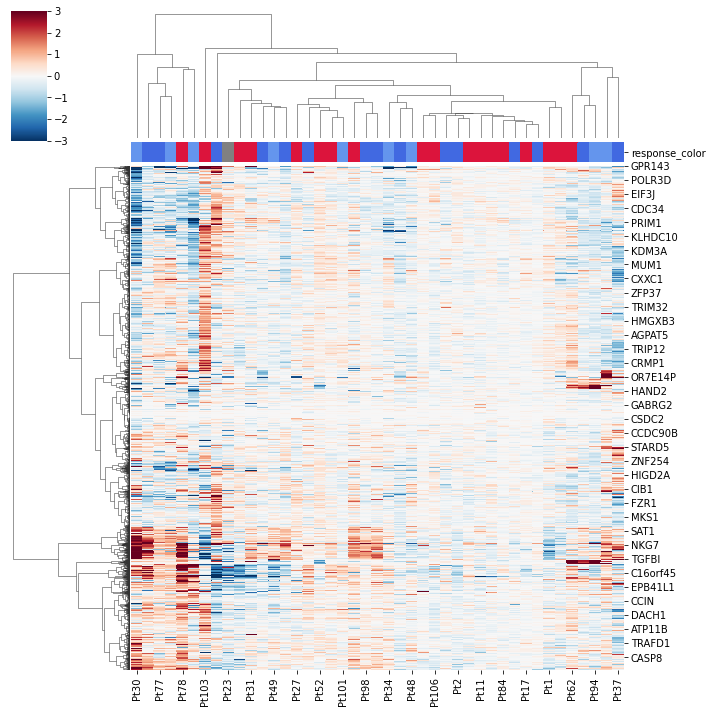

In [10]:
# differential between N and NR in On-treatment - Pre-treatment
log2exp2_91061_fc = df(index=log2exp2_91061.index, columns=paired_91061.index)
for p in log2exp2_91061_fc.columns:
    log2exp2_91061_fc[p] = log2exp2_91061[paired_91061.loc[p, 'On']] - log2exp2_91061[paired_91061.loc[p, 'Pre']]

sns.clustermap(log2exp2_91061_fc,
               figsize=(10, 10),
               cmap='RdBu_r',
               z_score=None,
               vmin=-3,
               vmax=3,
               method='ward',
               col_colors=paired_91061['response_color'])
plt.show()

In [11]:
gene_sets = {}
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gene_sets[lines[0]] = lines[2:]
print(gene_sets.keys())

dict_keys(['NREC_profile', 'REC_profile'])


In [12]:
# z_score
z_ec_91061 = log2exp2_91061.T.apply(stats.zscore).T
mean_z_ec_91061 = df(index=log2exp2_91061.columns, columns=['TEC-S', 'TEC-R'])
for p in mean_z_ec_91061.index:
    mean_z_ec_91061.at[p, 'TEC-R'] = z_ec_91061[z_ec_91061.index.isin(gene_sets['NREC_profile'])][p].mean(axis=0)
    mean_z_ec_91061.at[p, 'TEC-S'] = z_ec_91061[z_ec_91061.index.isin(gene_sets['REC_profile'])][p].mean(axis=0)

In [13]:
mean_z_ec_91061['time'] = patient_color['time']
mean_z_ec_91061['response_color'] = patient_color['response_color']
mean_z_ec_91061['R-S'] = mean_z_ec_91061['TEC-R'] - mean_z_ec_91061['TEC-S']

In [28]:
mean_z_ec_91061['response_binary'] = 0
for p in mean_z_ec_91061.index:
    if p in patient_color.index and patient_color.loc[p, 'response'] == 'PD':
        mean_z_ec_91061.at[p, 'response_binary'] = 1

In [23]:
patient_color

,response,response_color,time,time_color
Pt1_Pre_AD101148-6,PD,crimson,Pre,violet
Pt1_On_AD174047-6,PD,crimson,On,gold
Pt2_Pre_AD101150-6,SD,royalblue,Pre,violet
Pt2_On_AD174046-6,SD,royalblue,On,gold
Pt23_On_AD486568-8,UNK,grey,On,gold
...,...,...,...,...
Pt44_On_AD167376-6,PRCR,cornflowerblue,On,gold
Pt106_Pre_AD502250-5,PD,crimson,Pre,violet
Pt106_On_AD513626-6,PD,crimson,On,gold
Pt34_On_AD485757-6,PRCR,cornflowerblue,On,gold


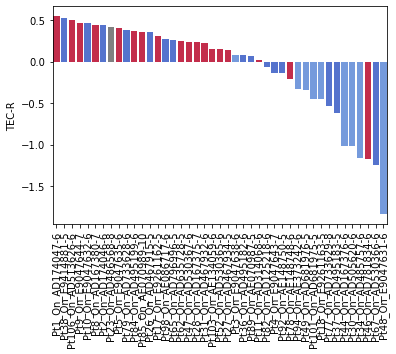

In [40]:
tmp = mean_z_ec_91061[mean_z_ec_91061['time'] == 'On'].sort_values(by='TEC-R', ascending=False)
sns.barplot(x=tmp.index, y='TEC-R', palette=tmp['response_color'],
            data=tmp)
plt.xticks(rotation=90)
plt.show()

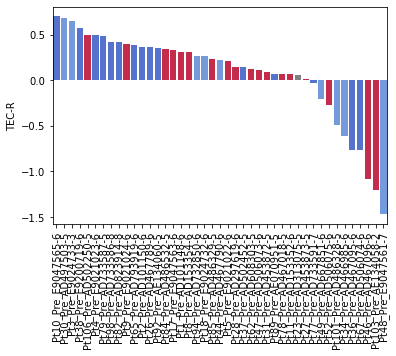

In [41]:
tmp = mean_z_ec_91061[mean_z_ec_91061['time'] == 'Pre'].sort_values(by='TEC-R', ascending=False)
sns.barplot(x=tmp.index, y='TEC-R', palette=tmp['response_color'],
            data=tmp)
plt.xticks(rotation=90)
plt.show()

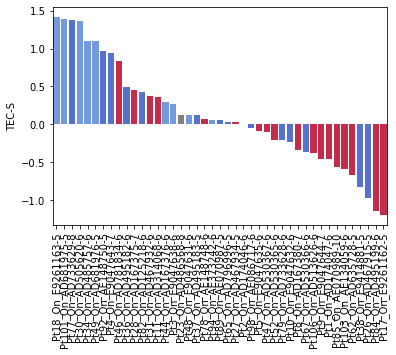

In [42]:
tmp = mean_z_ec_91061[mean_z_ec_91061['time'] == 'On'].sort_values(by='TEC-S', ascending=False)
sns.barplot(x=tmp.index, y='TEC-S', palette=tmp['response_color'],
            data=tmp)
plt.xticks(rotation=90)
plt.show()

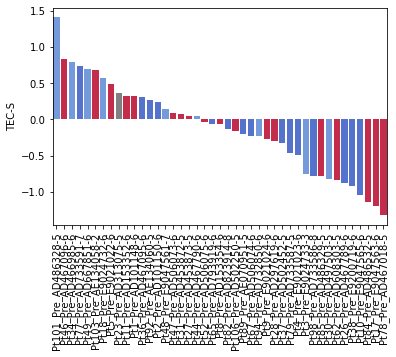

In [43]:
tmp = mean_z_ec_91061[mean_z_ec_91061['time'] == 'Pre'].sort_values(by='TEC-S', ascending=False)
sns.barplot(x=tmp.index, y='TEC-S', palette=tmp['response_color'],
            data=tmp)
plt.xticks(rotation=90)
plt.show()

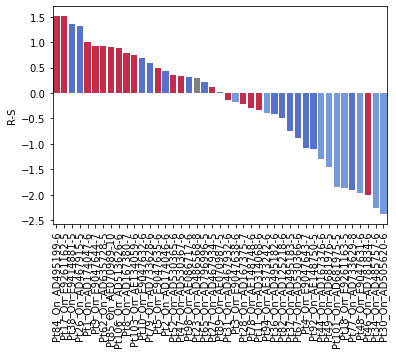

In [21]:
tmp = mean_z_ec_91061[mean_z_ec_91061['time'] == 'On'].sort_values(by='R-S', ascending=False)
sns.barplot(x=tmp.index, y='R-S', palette=tmp['response_color'],
            data=tmp)
plt.xticks(rotation=90)
plt.show()

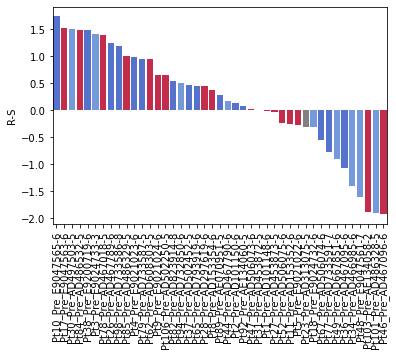

In [22]:
tmp = mean_z_ec_91061[mean_z_ec_91061['time'] == 'Pre'].sort_values(by='R-S', ascending=False)
sns.barplot(x=tmp.index, y='R-S', palette=tmp['response_color'],
            data=tmp)
plt.xticks(rotation=90)
plt.show()

In [30]:
fpr_rs, tpr_rs, _ = roc_curve(mean_z_ec_91061['response_binary'], mean_z_ec_91061['R-S'], pos_label=1)

0.6187214611872146


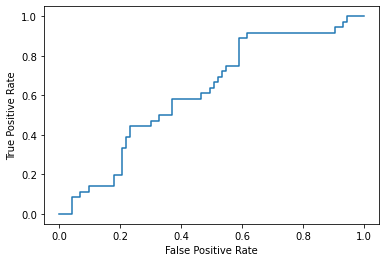

In [32]:
RocCurveDisplay(fpr=fpr_rs, tpr=tpr_rs).plot()
print(auc(fpr_rs, tpr_rs))

Pre
0.5066666666666666
On
0.7822222222222222


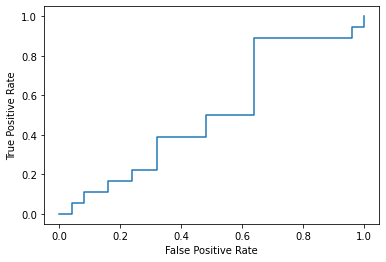

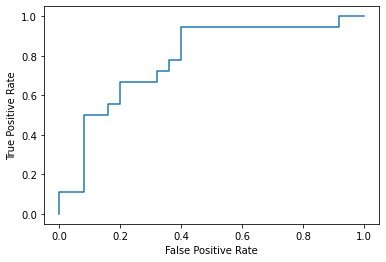

In [39]:
for t in ['Pre', 'On']:
    print(t)
    tmp = mean_z_ec_91061[mean_z_ec_91061['time'] == t]
    fpr_tmp, tpr_tmp, _ = roc_curve(tmp['response_binary'], tmp['R-S'], pos_label=1)
    RocCurveDisplay(fpr=fpr_tmp, tpr=tpr_tmp).plot()
    print(auc(fpr_tmp, tpr_tmp))

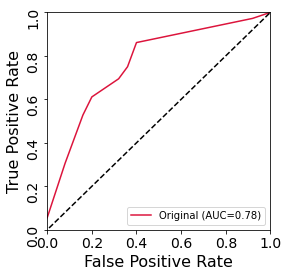

In [52]:
plt.figure(figsize=(4, 4))

# add ROCs
tmp = mean_z_ec_91061[mean_z_ec_91061['time'] == 'On']
fpr_tmp, tpr_tmp, _ = roc_curve(tmp['response_binary'], tmp['R-S'], pos_label=1)
g = sns.lineplot(x=fpr_tmp,
                 y=tpr_tmp,
                 ci=None,
                 color='crimson',
                 label='Original (AUC=' + str(np.round(auc(fpr_tmp, tpr_tmp), 2)) + ')')


# add x=y
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '--k')

# add labels
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.yticks(rotation=90, fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.xlim(0, 1)
plt.ylim(0, 1)
# plt.tight_layout()
fig = plt.gcf()
fig.savefig(auc_home + 'AUC_original.pdf', transparent=True)
fig.savefig(auc_home + 'AUC_original.png', dpi=300, transparent=True)

## 1.2 CXCL10 in R vs.S

In [14]:
tec_CXCL10 = df(log2exp2_91061_fc.loc['CXCL10', :])
tec_CXCL10['patient_response'] = paired_91061['response']

Text(0.5, 1.0, 'TEC of CXCL10 in anti-PD-1 treated patients')

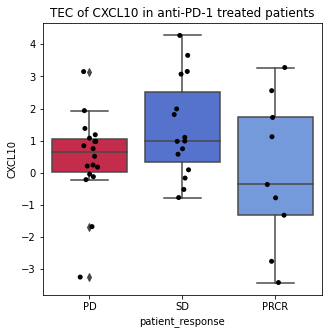

In [15]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='patient_response', y='CXCL10',
            order=['PD', 'SD', 'PRCR'],
            data=tec_CXCL10, palette=response_lut)
sns.stripplot(x='patient_response', y='CXCL10',
            order=['PD', 'SD', 'PRCR'],
            data=tec_CXCL10, color='k')
plt.title('TEC of CXCL10 in anti-PD-1 treated patients')

In [16]:
expr_CXCL10 = df(log2exp2_91061.loc['CXCL10', :])
expr_CXCL10['response'] = patient_color['response']
expr_CXCL10['time'] = patient_color['time']

In [17]:
expr_CXCL10

,CXCL10,response,time
Pt1_Pre_AD101148-6,6.767232,PD,Pre
Pt1_On_AD174047-6,5.090576,PD,On
Pt10_Pre_E9047565-6,4.233509,SD,Pre
Pt10_On_E9047632-6,6.048156,SD,On
Pt101_Pre_AD486328-5,6.977623,PRCR,Pre
...,...,...,...
Pt93_On_AE070988-5,3.992181,NaN,NaN
Pt94_Pre_AD732850-6,2.479184,PRCR,Pre
Pt94_On_AE373242-6,5.758586,PRCR,On
Pt98_Pre_AD733586-8,3.087527,SD,Pre


/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Expression of CXCL10 in anti-PD-1 treated patients')

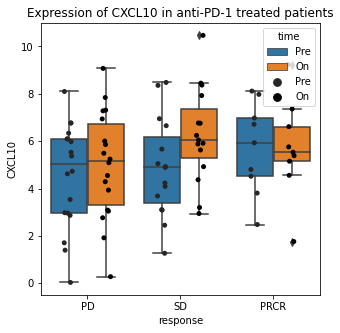

In [18]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='response', y='CXCL10',
            hue='time',
            order=['PD', 'SD', 'PRCR'],
            data=expr_CXCL10)
sns.stripplot(x='response', y='CXCL10',
            hue='time', split=True,
            order=['PD', 'SD', 'PRCR'],
            data=expr_CXCL10, color='k')
plt.title('Expression of CXCL10 in anti-PD-1 treated patients')

In [19]:
expr_LC3 = df(log2exp2_91061.loc['MAP1LC3B', :])
expr_LC3['response'] = patient_color['response']
expr_LC3['time'] = patient_color['time']

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Expression of MAP1LC3B in anti-PD-1 treated patients')

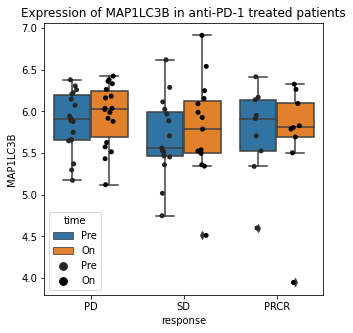

In [20]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='response', y='MAP1LC3B',
            hue='time',
            order=['PD', 'SD', 'PRCR'],
            data=expr_LC3)
sns.stripplot(x='response', y='MAP1LC3B',
            hue='time', split=True,
            order=['PD', 'SD', 'PRCR'],
            data=expr_LC3, color='k')
plt.title('Expression of MAP1LC3B in anti-PD-1 treated patients')

## 1.3 PAK expression in R vs. S

In [21]:
tec_PAK4 = df(log2exp2_91061_fc.loc[['PAK1', 'PAK2', 'PAK3', 'PAK4', 'PAK6'], :]).T
tec_PAK4['patient_response'] = paired_91061['response']

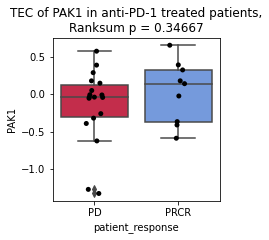

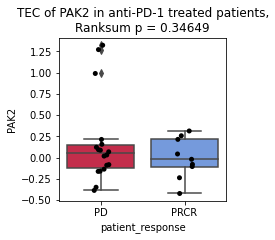

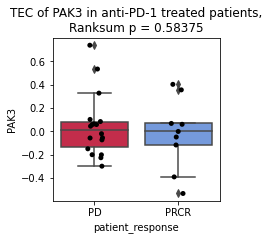

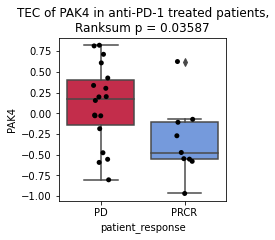

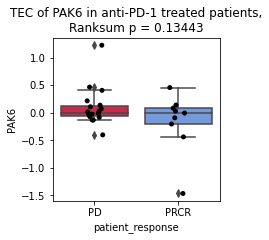

In [43]:
for g in ['PAK1', 'PAK2', 'PAK3', 'PAK4', 'PAK6']:
    p = stats.ttest_ind(tec_PAK4[tec_PAK4['patient_response'] == 'PD'][g],
                        tec_PAK4[tec_PAK4['patient_response'] == 'PRCR'][g])[1]
    plt.figure(figsize=(3, 3))
    sns.boxplot(x='patient_response', y=g,
                order=['PD', 'PRCR'],
                data=tec_PAK4, palette=response_lut)
    sns.stripplot(x='patient_response', y=g,
                order=['PD', 'PRCR'],
                data=tec_PAK4, color='k')
    plt.title('TEC of ' + g + ' in anti-PD-1 treated patients,\nRanksum p = ' + str(np.round(p, 5)))
    fig = plt.gcf()
    fig.savefig(poseidon_home + 'panels/Figure5/GSE91061_' + g + '.pdf', transparent=True)

Text(0.5, 1.0, 'TEC of PAK4 in anti-PD-1 treated patients')

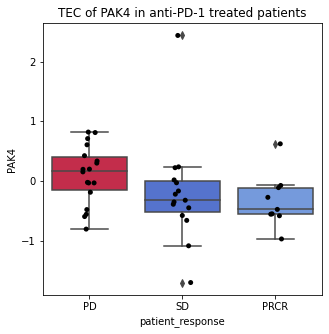

In [23]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='patient_response', y='PAK4',
            order=['PD', 'SD', 'PRCR'],
            data=tec_PAK4, palette=response_lut)
sns.stripplot(x='patient_response', y='PAK4',
            order=['PD', 'SD', 'PRCR'],
            data=tec_PAK4, color='k')
plt.title('TEC of PAK4 in anti-PD-1 treated patients')

Text(0.5, 1.0, 'TEC of PAK3 in anti-PD-1 treated patients')

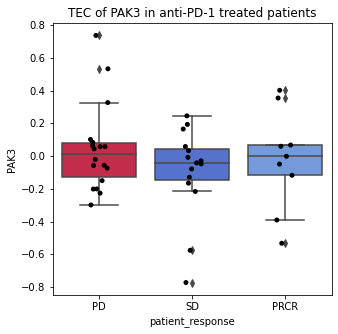

In [24]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='patient_response', y='PAK3',
            order=['PD', 'SD', 'PRCR'],
            data=tec_PAK4, palette=response_lut)
sns.stripplot(x='patient_response', y='PAK3',
            order=['PD', 'SD', 'PRCR'],
            data=tec_PAK4, color='k')
plt.title('TEC of PAK3 in anti-PD-1 treated patients')

Text(0.5, 1.0, 'TEC of PAK2 in anti-PD-1 treated patients')

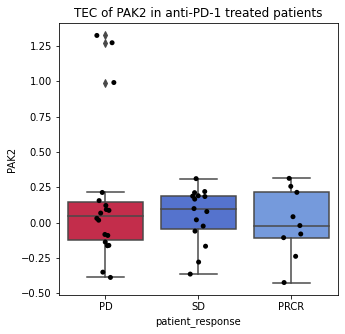

In [25]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='patient_response', y='PAK2',
            order=['PD', 'SD', 'PRCR'],
            data=tec_PAK4, palette=response_lut)
sns.stripplot(x='patient_response', y='PAK2',
            order=['PD', 'SD', 'PRCR'],
            data=tec_PAK4, color='k')
plt.title('TEC of PAK2 in anti-PD-1 treated patients')

Text(0.5, 1.0, 'TEC of PAK1 in anti-PD-1 treated patients')

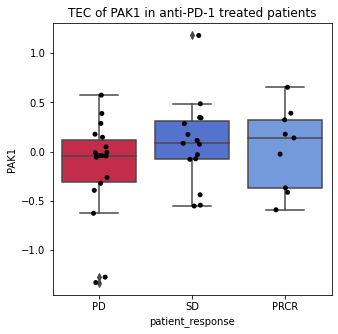

In [26]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='patient_response', y='PAK1',
            order=['PD', 'SD', 'PRCR'],
            data=tec_PAK4, palette=response_lut)
sns.stripplot(x='patient_response', y='PAK1',
            order=['PD', 'SD', 'PRCR'],
            data=tec_PAK4, color='k')
plt.title('TEC of PAK1 in anti-PD-1 treated patients')

Text(0.5, 1.0, 'TEC of PAK6 in anti-PD-1 treated patients')

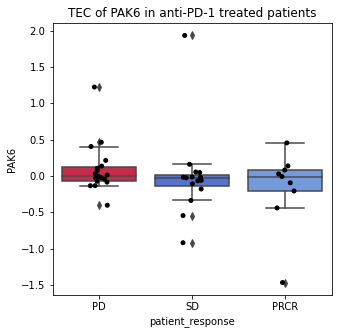

In [27]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='patient_response', y='PAK6',
            order=['PD', 'SD', 'PRCR'],
            data=tec_PAK4, palette=response_lut)
sns.stripplot(x='patient_response', y='PAK6',
            order=['PD', 'SD', 'PRCR'],
            data=tec_PAK4, color='k')
plt.title('TEC of PAK6 in anti-PD-1 treated patients')

In [28]:
expr_PAK4 = df(log2exp2_91061.loc['PAK4', :])
expr_PAK4['response'] = patient_color['response']
expr_PAK4['time'] = patient_color['time']

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Expression of PAK4 in anti-PD-1 treated patients')

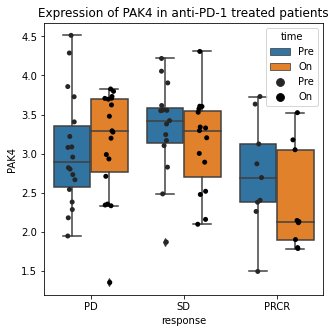

In [69]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='response', y='PAK4',
            hue='time',
            order=['PD', 'SD', 'PRCR'],
            data=expr_PAK4)
sns.stripplot(x='response', y='PAK4',
            hue='time', color='k', split=True,
            order=['PD', 'SD', 'PRCR'],
            data=expr_PAK4)
plt.title('Expression of PAK4 in anti-PD-1 treated patients')

## 1.3 PAK4 vs. CXCL10 in all groups

<AxesSubplot:xlabel='CXCL10', ylabel='PAK4'>

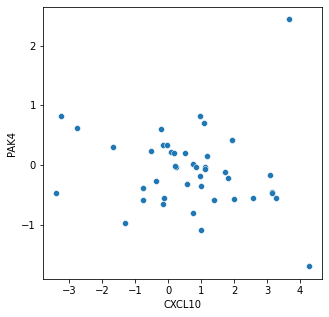

In [51]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='CXCL10', y='PAK4', data=log2exp2_91061_fc.T)

<AxesSubplot:xlabel='CXCL10', ylabel='MAP1LC3B'>

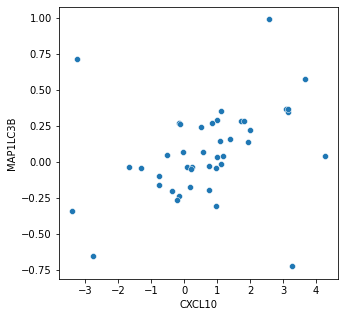

In [67]:
# LC3
plt.figure(figsize=(5, 5))
sns.scatterplot(x='CXCL10', y='MAP1LC3B', data=log2exp2_91061_fc.T)

<AxesSubplot:xlabel='PAK4', ylabel='MAP1LC3B'>

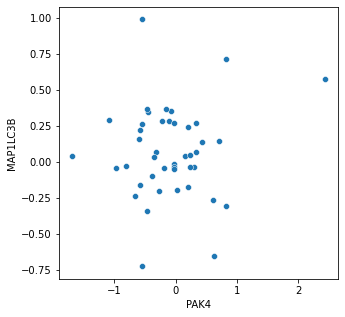

In [68]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='PAK4', y='MAP1LC3B', data=log2exp2_91061_fc.T)

<AxesSubplot:xlabel='CXCL10', ylabel='PAK4'>

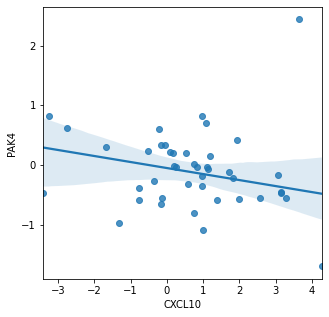

In [59]:
plt.figure(figsize=(5, 5))
sns.regplot(x='CXCL10', y='PAK4', robust=True, data=log2exp2_91061_fc.T)

<AxesSubplot:xlabel='CXCL10', ylabel='PAK4'>

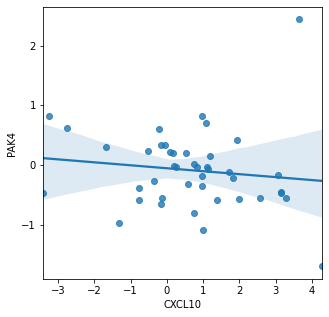

In [60]:
plt.figure(figsize=(5, 5))
sns.regplot(x='CXCL10', y='PAK4', data=log2exp2_91061_fc.T)

In [55]:
log2exp2_91061_fc.T[['CXCL10', 'PAK4']]

,CXCL10,PAK4
Pt1,-1.676657,0.300680
Pt2,0.092181,0.223901
Pt23,-0.166630,0.332789
Pt82,1.103099,-0.028465
Pt49,1.121925,-0.073516
Pt85,0.176889,0.196580
Pt89,3.073402,-0.165925
Pt101,-0.364582,-0.272261
Pt47,-0.042484,0.335564
Pt52,0.514021,0.200299


In [56]:
paired_91061.loc['Pt36', :]

Pre               Pt36_Pre_AD467095-6
On                 Pt36_On_AD495182-6
response                           SD
response_color              royalblue
Name: Pt36, dtype: object

In [39]:
case_tec = log2exp2_91061_fc.drop(columns=['Pt36']).T
case_tec['response'] = paired_91061['response']
stats.pearsonr(case_tec['CXCL10'], case_tec['PAK4'])

(-0.37947865274037995, 0.013190800575279814)

In [40]:
stats.pearsonr(case_tec['CXCL10'], case_tec['PAK3'])

(-0.06674023128458956, 0.674527916588831)

In [41]:
stats.pearsonr(case_tec['CXCL10'], case_tec['PAK2'])

(0.026315886776563643, 0.8686070271213627)

In [42]:
stats.pearsonr(case_tec['CXCL10'], case_tec['PAK1'])

(0.5226794282196396, 0.00038378844760805227)

<AxesSubplot:xlabel='CXCL10', ylabel='PAK4'>

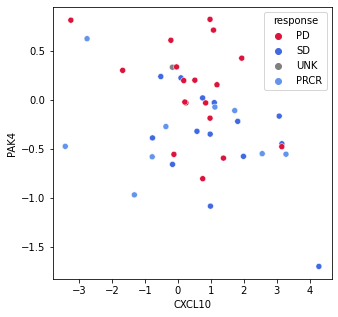

In [76]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='CXCL10', y='PAK4', hue='response', palette=response_lut, data=case_tec)

(-0.2163321306842901, 0.16880921011981845)

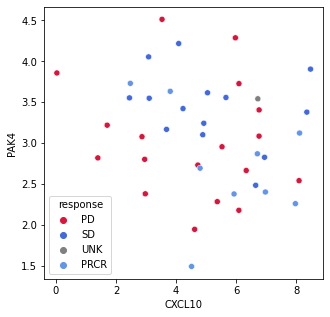

In [84]:
case_pre = df(log2exp2_91061.loc[['CXCL10', 'PAK4'], paired_91061['Pre']]).T.drop(index=['Pt36_Pre_AD467095-6'])
case_pre['response'] = patient_color['response']

plt.figure(figsize=(5, 5))
sns.scatterplot(x='CXCL10', y='PAK4', hue='response', palette=response_lut, data=case_pre)
stats.pearsonr(case_pre['CXCL10'], case_pre['PAK4'])

(-0.10333358584104922, 0.5149076869689709)

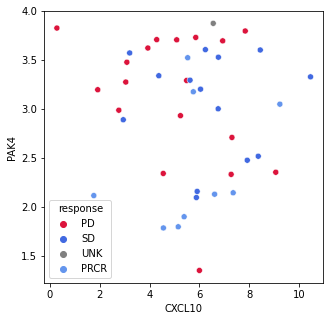

In [90]:
case_on = df(log2exp2_91061.loc[['CXCL10', 'PAK4'], paired_91061['On']]).T.drop(index=['Pt36_On_AD495182-6'])
case_on['response'] = patient_color['response']

plt.figure(figsize=(5, 5))
sns.scatterplot(x='CXCL10', y='PAK4', hue='response', palette=response_lut, data=case_on)
stats.pearsonr(case_on['CXCL10'], case_on['PAK4'])

<AxesSubplot:xlabel='CXCL10', ylabel='PAK4'>

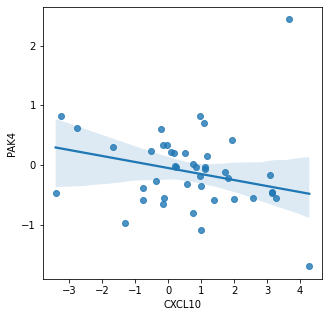

In [35]:
# All PAKs with CXCL10
plt.figure(figsize=(5, 5))
sns.regplot(x='CXCL10', y='PAK4', robust=True, data=log2exp2_91061_fc.T)

<AxesSubplot:xlabel='CXCL10', ylabel='PAK3'>

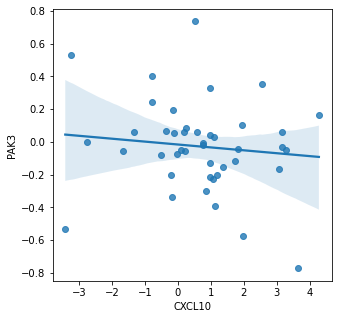

In [36]:
plt.figure(figsize=(5, 5))
sns.regplot(x='CXCL10', y='PAK3', robust=True, data=log2exp2_91061_fc.T)

<AxesSubplot:xlabel='CXCL10', ylabel='PAK2'>

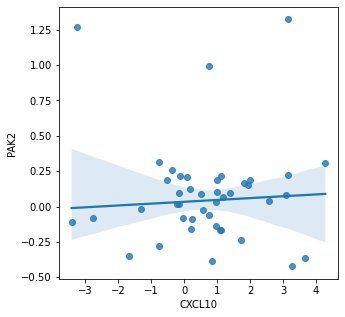

In [37]:
plt.figure(figsize=(5, 5))
sns.regplot(x='CXCL10', y='PAK2', robust=True, data=log2exp2_91061_fc.T)

<AxesSubplot:xlabel='CXCL10', ylabel='PAK1'>

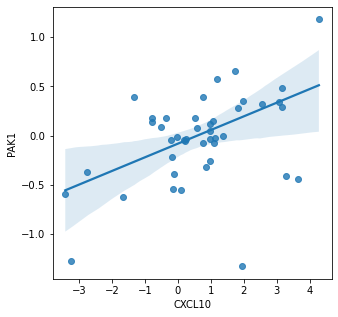

In [38]:
plt.figure(figsize=(5, 5))
sns.regplot(x='CXCL10', y='PAK1', robust=True, data=log2exp2_91061_fc.T)

In [45]:
stats.pearsonr(log2exp2_91061_fc.T['CXCL10'], log2exp2_91061_fc.T['PAK4'])

(-0.12837119055086288, 0.4119974897740381)

In [46]:
stats.pearsonr(log2exp2_91061_fc.T['CXCL10'], log2exp2_91061_fc.T['PAK3'])

(-0.17318749500336134, 0.2667320729115778)

In [47]:
stats.pearsonr(log2exp2_91061_fc.T['CXCL10'], log2exp2_91061_fc.T['PAK2'])

(-0.02836411999374864, 0.8567196843248414)

In [48]:
stats.pearsonr(log2exp2_91061_fc.T['CXCL10'], log2exp2_91061_fc.T['PAK1'])

(0.4604456695319103, 0.001890385579171883)

In [55]:
stats.pearsonr(log2exp2_91061_fc.T['CXCL10'], log2exp2_91061_fc.T['PAK6'])

(-0.13043752865063846, 0.4044488213646038)

In [59]:
stats.pearsonr(log2exp2_91061_fc.T['CXCL10'], log2exp2_91061_fc.T['MAP1LC3B'])

(0.3302363683776211, 0.030558425820790807)

## 1.4 all potent synergy target genes association with CXCL10

In [163]:
potent_hit = ['CDK2', 'RRM1', 'BIRC5', 'PPIA', 'HMGCR',
              'HSP90AA1', 'PAK4', 'FKBP1A', 'IGF1R', 'AURKA',
              'CDK4', 'PLK1', 'DHFR', 'TYMS', 'ACLY', 'PRKDC',
              'AKT3', 'HDAC2', 'PARP1', 'ATP1A1', 'PTK2', 'MET',
              'CSNK1E', 'CTNNB1']

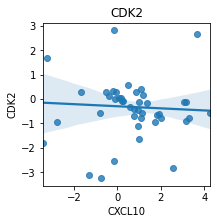

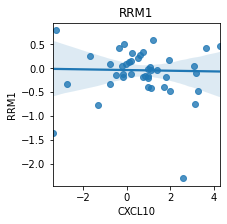

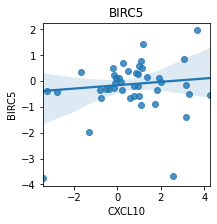

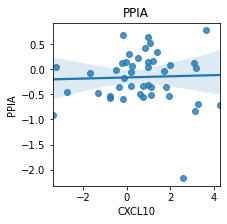

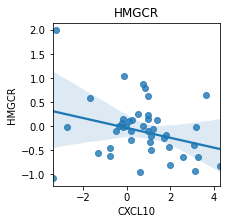

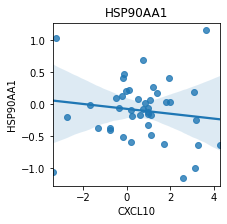

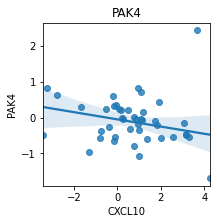

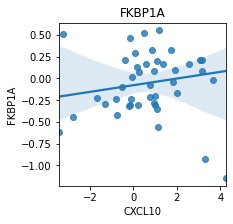

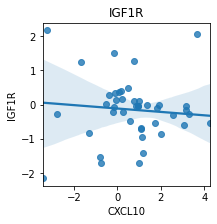

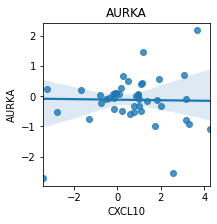

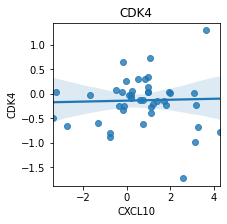

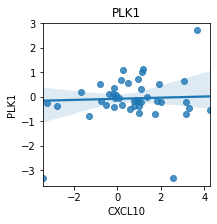

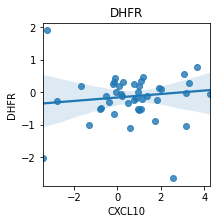

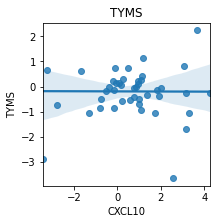

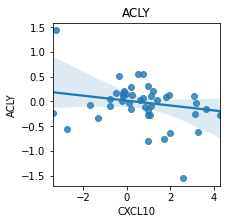

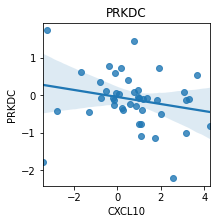

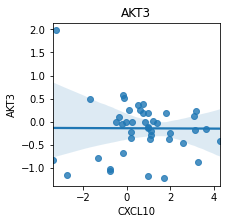

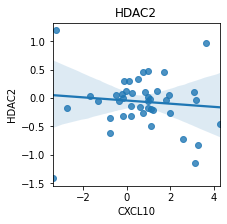

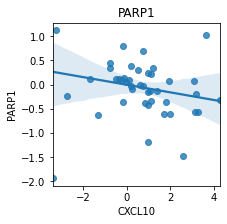

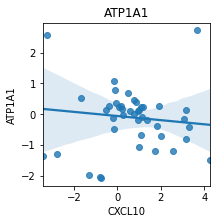

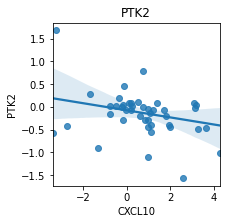

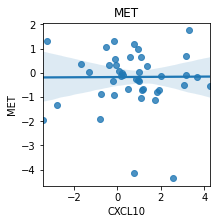

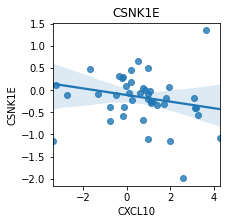

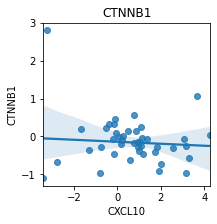

In [165]:
for g in potent_hit:
    plt.figure(figsize=(3, 3))
    sns.regplot(x='CXCL10', y=g, robust=True, data=log2exp2_91061_fc.T)
    plt.title(g)
    plt.show()

In [166]:
primary_selection = ['HMGCR', 'PAK4', 'ACLY', 'PRKDC', 'AKT3', 'PARP1', 'ATP1A1', 'PTK2', 'CSNK1E']

In [168]:
compound_info[compound_info['target'].isin(primary_selection)]['moa'].unique()

array(['PARP inhibitor', 'ATP citrase lyase inhibitor', 'Akt inhibitor',
       'Casein kinase inhibitor', 'MTOR inhibitor',
       'P-glycoprotein inhibitor', 'P21 activated kinase inhibitor',
       'DNA dependent protein kinase inhibitor',
       'Neurotransmitter agonist', 'Gluconeogenesis inhibitor',
       'ATPase inhibitor', 'HMGCR inhibitor',
       'Membrane integrity inhibitor', 'Focal adhesion kinase inhibitor',
       'Protein synthesis stimulant'], dtype=object)

# 2. CXCL10 expression in GSE168204

In [29]:
# GSE168204 original expression
expr_168204 = pd.read_csv(data_home + 'GSE168204/GSE168204_MGH_counts_cleaned.csv',
                          index_col=0, header=0, sep=',')
expr_168204.shape

(75253, 27)

In [30]:
# overlap with the L1000 space
expr_168204 = expr_168204[expr_168204.index.isin(bing_landmark['Official NCBI gene symbol'])]

# read clinical information
info_168204 = pd.read_csv(data_home + 'GSE168204/GSE168204_patient_info.csv',
                          index_col=0, header=0, sep=',')
print(expr_168204.shape, info_168204.shape)

(10059, 27) (27, 2)


In [31]:
pd.crosstab(info_168204['time'], info_168204['response'])

response,NR,R
time,,
POST,13,4
PRE,5,5


In [32]:
log2exp2_168204 = np.log2(expr_168204 + 1)
# collapse duplicates
log2exp2_168204 = log2exp2_168204.groupby(level=0).mean()

In [33]:
# add color
lut_168204 = {'R': {'PRE': 'royalblue', 'POST': 'lightsteelblue'}, 'NR': {'PRE': 'crimson', 'POST': 'pink'}}
info_168204['colorbar'] = ''
for p in info_168204.index:
    info_168204.at[p, 'colorbar'] = lut_168204[info_168204.loc[p, 'response']][info_168204.loc[p, 'time']]

In [34]:
info_168204['patient'] = 'not_available'
for p in info_168204.index:
    info_168204.at[p, 'patient'] = p.split('_')[0]

In [35]:
info_168204.groupby('patient').count()

,time,response,colorbar
patient,,,
148-12-13-14,1,1,1
MGH200,2,2,2
MGH253,2,2,2
MGH27,2,2,2
MGH35,1,1,1
MGH409,1,1,1
MGH51-041814,1,1,1
MGH51-081413,1,1,1
MGH530,3,3,3


In [36]:
log2exp2_168204

,MGH200_FFPE_031116,MGH200_FFPE_072716,MGH530_FFPE_082916,MGH530_FFPE_091916,MGH530_FFPE_032417,MGHBI1_101415,MGHIPIPD1001_041814,MGHIPIPD1001_092414,MGHIPIPD1001_070215-1,MGHIPIPD1001_070215-2,...,MGH253_111214,MGH253_070616,MGH409_113015,MGH51-081413,MGH51-041814,MGH98-030314,MGH98-051514,MGHPDL002-061812,MGHPDL002-080112,148-12-13-14_S10
Gene,,,,,,,,,,,,,,,,,,,,,
A2M,14.564626,14.713333,13.436191,15.445500,12.203960,13.002991,13.697945,14.466076,14.957692,13.745359,...,12.011577,10.753217,14.963619,13.216897,13.910924,11.949827,13.139871,13.773757,13.563435,11.942515
A4GALT,8.741467,7.348728,7.870365,10.143383,0.000000,5.754888,9.014020,8.991522,8.164907,8.686501,...,6.209453,5.643856,11.749869,9.174926,6.409391,6.977280,9.071462,8.243174,8.842350,2.000000
AAAS,7.499846,7.426265,7.276124,9.375039,4.807355,6.643856,8.668885,8.951285,9.049849,8.370687,...,9.824959,8.299208,8.383704,8.209453,8.209453,8.134426,7.149747,8.405141,8.169925,4.807355
AACS,7.066089,8.836050,6.930737,8.566054,5.554589,7.531381,10.262095,11.819780,11.035486,10.756556,...,10.195987,9.348728,8.636625,10.463524,7.912889,9.131857,10.022368,8.550747,7.960002,6.906891
AADAC,4.000000,6.087463,4.857981,5.700440,0.000000,0.000000,1.000000,2.000000,1.000000,7.219169,...,0.000000,1.000000,6.727920,8.290019,3.700440,1.000000,8.487840,1.000000,4.643856,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWINT,0.000000,1.584963,2.321928,0.000000,0.000000,3.169925,4.700440,5.426265,6.044394,4.643856,...,5.321928,8.184875,2.000000,4.321928,3.584963,2.321928,2.807355,5.129283,4.169925,NaN
ZXDC,9.611025,9.972980,10.594325,11.830119,8.588715,8.335390,9.813781,10.578373,9.310613,8.588715,...,8.000000,9.616549,9.084808,9.066089,9.564149,9.292322,8.491853,9.784635,9.840778,NaN
ZYX,11.832099,12.276415,10.419960,12.942515,10.899357,11.813380,11.948732,11.508290,10.478770,10.539159,...,11.878051,11.312316,11.875749,12.370687,11.259155,10.646559,11.388017,12.003869,11.748612,NaN


In [37]:
expr_case_168204 = df(log2exp2_168204.loc[['CXCL10', 'PAK4'], :].T)

In [38]:
expr_case_168204['time'] = info_168204['time']
expr_case_168204['response'] = info_168204['response']

<AxesSubplot:xlabel='CXCL10', ylabel='PAK4'>

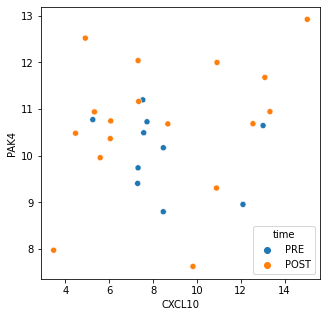

In [39]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='CXCL10', y='PAK4', hue='time', data=expr_case_168204)

<AxesSubplot:xlabel='CXCL10', ylabel='PAK4'>

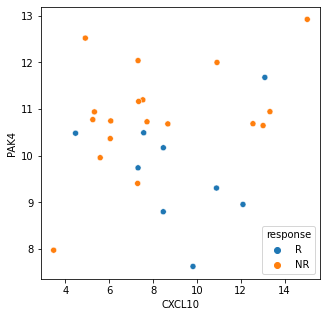

In [40]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='CXCL10', y='PAK4', hue='response', data=expr_case_168204)

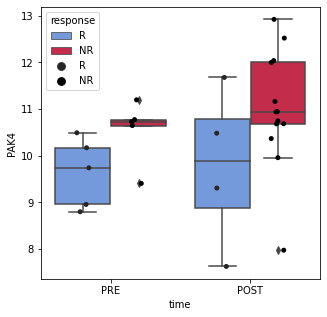

In [45]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='time', y='PAK4',
            hue='response', palette={'NR': 'crimson', 'R': 'cornflowerblue'},
            data=expr_case_168204)
sns.stripplot(x='time', y='PAK4',
            hue='response', color='k', dodge=True,
            data=expr_case_168204)
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/Figure5/GSE168204_PAK4.pdf', transparent=True)

In [ ]:
sns.boxplot(x='time', y='PAK4',
            hue='response', palette={'NR': 'crimson', 'R': 'royalblue'},

<AxesSubplot:xlabel='time', ylabel='CXCL10'>

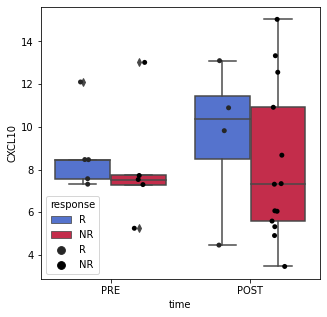

In [42]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='time', y='CXCL10',
            hue='response', palette={'NR': 'crimson', 'R': 'royalblue'},
            data=expr_case_168204)
sns.stripplot(x='time', y='CXCL10',
            hue='response', color='k', dodge=True,
            data=expr_case_168204)

# 3. shRNAs and compounds targeting PAK4 in CMAP2020

In [5]:
sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/siginfo_beta.txt',
                            header=0, index_col='sig_id', sep='\t')
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
shRNA_PAK4 = sig_info[sig_info['cmap_name'] == 'PAK4']
shRNA_PAK4.shape

(117, 36)

In [7]:
compound_PAK4 = sig_info[sig_info['cmap_name'] == 'PF-03758309']
compound_PAK4.shape

(303, 36)

## 3.1 check TAS

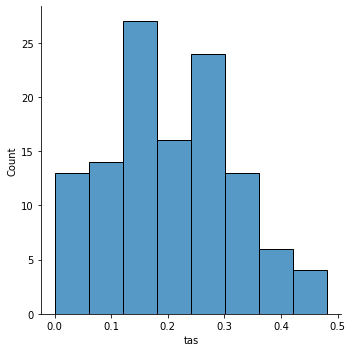

In [8]:
sns.displot(x='tas', data=shRNA_PAK4)

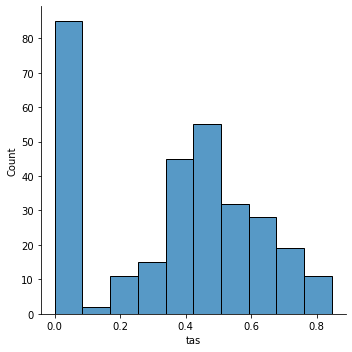

In [129]:
sns.displot(x='tas', data=compound_PAK4)

## 3.2 read CMAP2020 expression

In [9]:
cxcl10_cp_cmap = pd.read_csv(poseidon_home + 'ICD/ICD_selected_expr_matrix.csv',
                             header=0, index_col=0, sep=',')
cxcl10_cp_pak4 = cxcl10_cp_cmap[cxcl10_cp_cmap.index.isin(compound_PAK4.index)]

In [10]:
cxcl10_cp_pak4

,IL17B,ANXA1,HMGB1,IL1B,CXCL10,CALR,cancer_type,time,tas,cell_line
LJP009_MCF7_24H:D02,2.186150,-2.409550,-4.415750,-0.689550,0.069900,-3.952850,BRCA,24.0,0.560981,MCF7
REP.A014_MCF7_24H:K13,-1.527650,1.213900,-3.441600,4.282500,2.340300,-3.283650,BRCA,24.0,0.779119,MCF7
REP.A014_MCF7_24H:K14,-0.088806,0.272801,-1.912339,-0.627591,0.594935,-2.439867,BRCA,24.0,0.570876,MCF7
REP.A014_MCF7_24H:K15,0.528291,-0.068820,-1.753598,-0.001981,0.150321,-0.682002,BRCA,24.0,0.495805,MCF7
REP.A014_MCF7_24H:K16,0.920248,0.187823,-1.349970,0.155951,-0.190405,-1.266179,BRCA,24.0,0.478883,MCF7
...,...,...,...,...,...,...,...,...,...,...
REP.A014_A375_24H:K16,-0.141650,1.552600,-1.332950,-0.146650,0.938500,-0.761000,SKCM,24.0,0.459211,A375
REP.A014_A375_24H:K17,-0.118900,-0.228350,-0.495700,-0.450100,0.091350,-1.178650,SKCM,24.0,0.465950,A375
REP.B014_A375_24H:K13,0.700200,-0.037150,-0.726250,-0.936050,-0.168350,-1.764550,SKCM,24.0,0.480462,A375
REP.B014_A375_24H:K14,0.448000,0.473300,-0.464500,-0.206200,0.152500,0.393800,SKCM,24.0,0.438522,A375


<AxesSubplot:xlabel='cell_line', ylabel='CXCL10'>

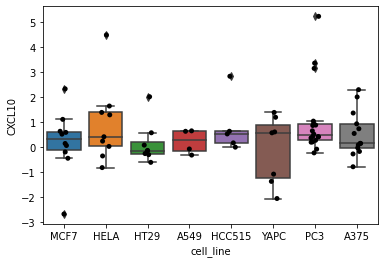

In [11]:
sns.boxplot(x='cell_line', y='CXCL10', data=cxcl10_cp_pak4)
sns.stripplot(x='cell_line', y='CXCL10', color='k', data=cxcl10_cp_pak4)

In [ ]:
# shift ability of PAK4 inhibitors


## 3.3 Correlation between CXCL10 and shift ability

In [143]:
corr_cxcl10_shift = df(pd.read_csv(poseidon_home + 'ICD/ICD_shift/corr_ICD_shift_spearmanr.csv',
                                   header=0, index_col=0, sep=',')['CXCL10']).rename(columns={'CXCL10': 'spearman_r'})
corr_cxcl10_shift['spearman_p'] = pd.read_csv(poseidon_home + 'ICD/ICD_shift/corr_ICD_shift_spearmanp.csv',
                                              header=0, index_col=0, sep=',')['CXCL10']
corr_cxcl10_shift_info = pd.read_csv(poseidon_home + 'ICD/ICD_shift/corr_ICD_shift_spearman_info.csv',
                                     header=0, index_col=0, sep=',')

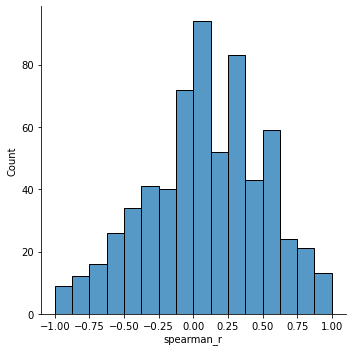

In [145]:
sns.displot(corr_cxcl10_shift['spearman_r'])

In [148]:
corr_cxcl10_shift.sort_values(by='spearman_r', ascending=False)[:50]

,spearman_r,spearman_p
HS578T_BMS-387032,1.000000,1.404265e-24
A375_cabazitaxel,0.942857,4.804665e-03
HT29_NVP-BEZ235,0.900000,9.430623e-04
A549_floxuridine,0.900000,3.738607e-02
A375_AT-7519,0.900000,3.738607e-02
A375_apicidin,0.900000,3.738607e-02
YAPC_cobimetinib,0.900000,3.738607e-02
PC3_BRD-K61717269,0.900000,3.738607e-02
A375_pyrimethamine,0.900000,3.738607e-02
HEPG2_gemcitabine,0.900000,3.738607e-02


In [159]:
# show only pairs with 9 or more experiment
top_cp_cxcl10_shift = corr_cxcl10_shift[corr_cxcl10_shift.index.isin(corr_cxcl10_shift_info[corr_cxcl10_shift_info['#experiment'] >= 9].index)].sort_values(by='spearman_r', ascending=False)[:50]

In [161]:
top_cp_cxcl10_shift['#experiment'] = corr_cxcl10_shift_info['#experiment']
top_cp_cxcl10_shift['moa'] = corr_cxcl10_shift_info['moa']
top_cp_cxcl10_shift['cancer'] = corr_cxcl10_shift_info['cancer']

In [162]:
top_cp_cxcl10_shift

,spearman_r,spearman_p,#experiment,moa,cancer
HT29_NVP-BEZ235,0.900000,9.430623e-04,9,MTOR inhibitor,CRC
A375_MK-1775,0.750000,1.994213e-02,9,WEE1 kinase inhibitor,SKCM
A375_gemcitabine,0.729412,1.343079e-03,16,Ribonucleotide reductase inhibitor,SKCM
A375_dinaciclib,0.720280,8.239769e-03,12,CDK inhibitor,SKCM
A375_panobinostat,0.657343,2.018550e-02,12,HDAC inhibitor,SKCM
A375_BRD-K54606188,0.633333,6.708579e-02,9,NaN,SKCM
A375_Ro-4987655,0.609091,4.669571e-02,11,MEK inhibitor,SKCM
MDAMB231_MLN-0128,0.592857,1.984642e-02,15,NaN,BRCA
PC3_clofarabine,0.591209,2.597081e-02,14,Ribonucleoside reductase inhibitor,PRAD
A375_tozasertib,0.587912,3.458606e-02,13,JAK inhibitor,SKCM
